In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorboard
import numpy as np
import logging
from datetime import datetime
import matplotlib.pyplot as plt

from utility import *

logging.getLogger().setLevel(logging.INFO)

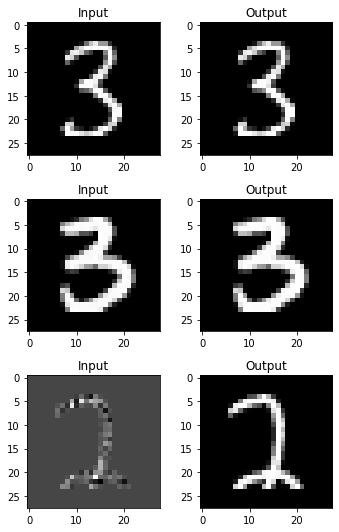

In [2]:
REFRESH_DATA = False
data = get_data(REFRESH_DATA)
plot_image_pairs(data, ('Input', 'Output'), first_n_pairs=3)

In [3]:
(x_train, y_train), (x_val, y_val) = get_train_val_pair(data)
logging.info(f"Total training images: {len(x_train)}")
logging.info(f"Total validation images: {len(x_val)}")

INFO:root:Total training images: 238000
INFO:root:Total validation images: 42000


In [4]:
image_shape = x_train.shape[-2:]
total_pixels = np.prod(image_shape)

In [5]:
inputs = keras.Input(shape=image_shape, name='input_layer')
flatten = keras.layers.Flatten(name='flatten_input_layer')(inputs)
h1 = keras.layers.Dense(128, activation='relu', name='hidden_layer_1') (flatten)
h2 = keras.layers.Dense(256, activation='relu', name='hidden_layer_2') (h1)
h3 = keras.layers.Dense(512, activation='relu', name='hidden_layer_3') (h2)
outputs = keras.layers.Dense(total_pixels, activation='relu', name='output_layer') (h3)
reshape =  keras.layers.Reshape((28,28), name='reshape_output_layer') (outputs)
model = keras.Model(inputs=inputs, outputs=reshape, name = 'MLP')
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='MSE',
    metrics=['accuracy']
)

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28)]          0         
_________________________________________________________________
flatten_input_layer (Flatten (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               100480    
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               33024     
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 512)               131584    
_________________________________________________________________
output_layer (Dense)         (None, 784)               402192    
_________________________________________________________________
reshape_output_layer (Reshap (None, 28, 28)            0       

In [6]:
logdir = "./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=logdir,
    histogram_freq=1
)

earlystop_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-4,
    patience=5
)

history = model.fit(
    x_train, 
    y_train, 
    batch_size = 512,
    epochs=50,
    validation_split=0.2,
    use_multiprocessing=True,
    callbacks=[earlystop_callback]
)

Train on 190400 samples, validate on 47600 samples
Epoch 1/50
190400/190400 [==============================] - 8s 41us/sample - loss: 0.0223 - accuracy: 0.4835 - val_loss: 0.0137 - val_accuracy: 0.5458
Epoch 2/50
190400/190400 [==============================] - 7s 36us/sample - loss: 0.0127 - accuracy: 0.5545 - val_loss: 0.0121 - val_accuracy: 0.5662
Epoch 3/50
190400/190400 [==============================] - 7s 37us/sample - loss: 0.0115 - accuracy: 0.5646 - val_loss: 0.0111 - val_accuracy: 0.5703
Epoch 4/50
190400/190400 [==============================] - 7s 38us/sample - loss: 0.0106 - accuracy: 0.5714 - val_loss: 0.0103 - val_accuracy: 0.5748
Epoch 5/50
190400/190400 [==============================] - 7s 37us/sample - loss: 0.0099 - accuracy: 0.5766 - val_loss: 0.0098 - val_accuracy: 0.5789
Epoch 6/50
190400/190400 [==============================] - 7s 38us/sample - loss: 0.0095 - accuracy: 0.5809 - val_loss: 0.0095 - val_accuracy: 0.5834
Epoch 7/50
190400/190400 [=================

In [7]:
x_val.shape

(42000, 28, 28)

In [8]:
def plot_image_pairs(image_pairs, image_pair_descs, first_n_pairs = 5):
    assert len(image_pairs) == len(image_pair_descs)
    n_pairs = len(image_pairs)
    fig_size = (2.5 * n_pairs, 2.5 * first_n_pairs)
    fig, axes = plt.subplots(first_n_pairs, n_pairs, figsize = fig_size)
    for i, (image_pair, image_pair_desc) in enumerate(zip(image_pairs, image_pair_descs)):
        images = image_pair[:first_n_pairs]
        for idx, image in enumerate(images):
            ax = axes[idx, i]
            ax.imshow(image, cmap = 'gray')
            ax.set_title(image_pair_desc)
    plt.tight_layout()
    plt.savefig('img3.png')
    plt.show()

In [9]:
y_val_pred = model.predict(x_val)

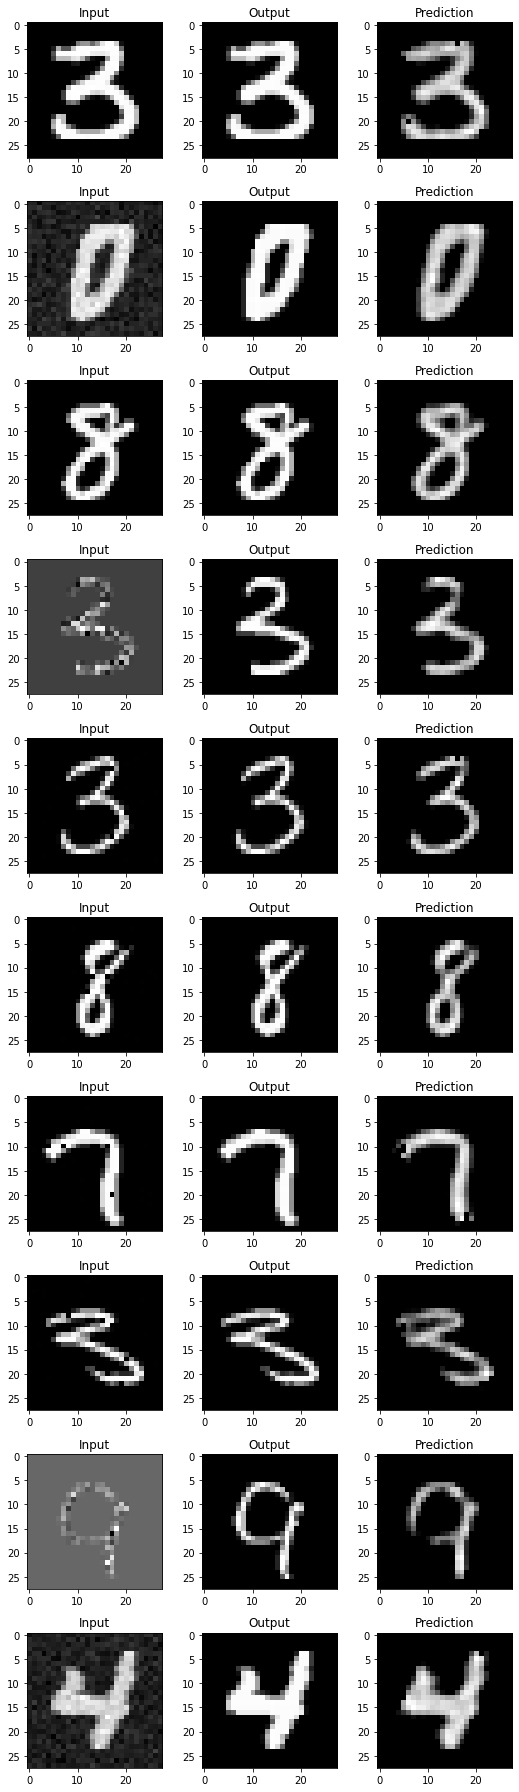

In [10]:
plot_image_pairs((x_val[50:,:,:], y_val[50:,:,:], y_val_pred[50:,:,:]), ('Input', 'Output','Prediction'), first_n_pairs = 10)

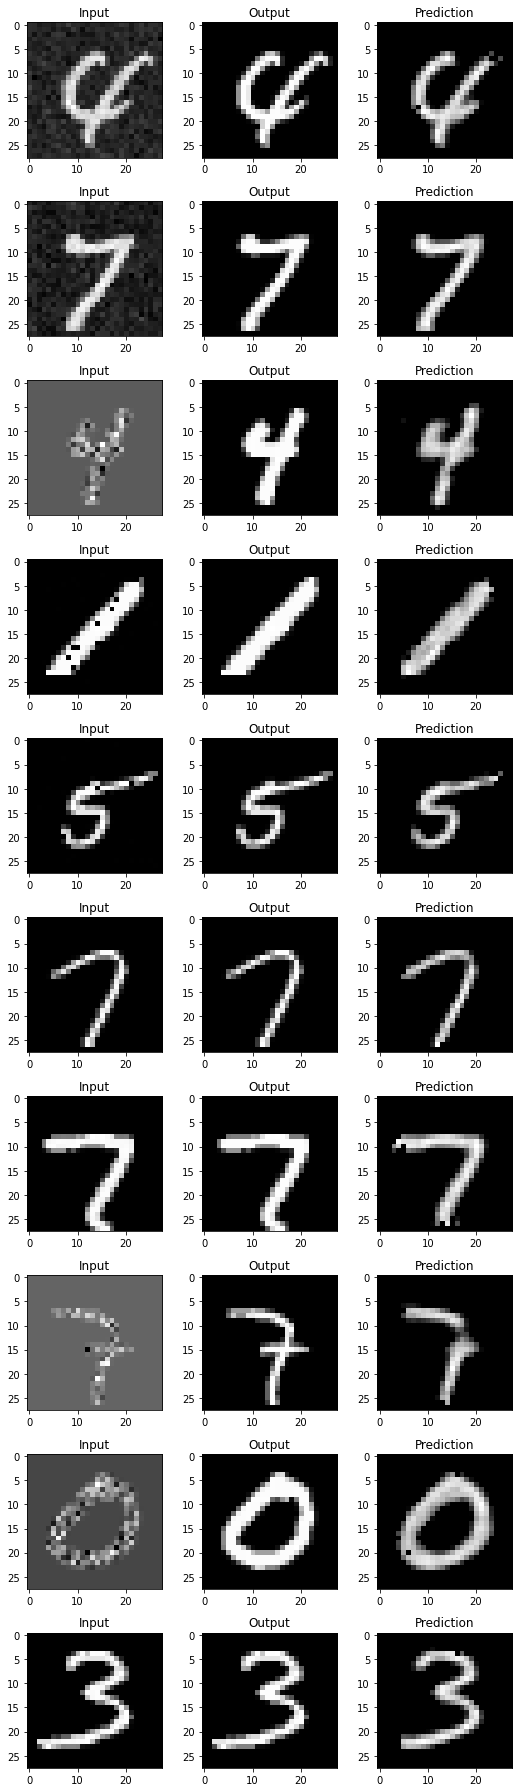

In [11]:
plot_image_pairs((x_val, y_val, y_val_pred), ('Input', 'Output','Prediction'), first_n_pairs = 10)

In [12]:
from noisy import *

In [13]:
(images, _), _ = keras.datasets.mnist.load_data()
sample_image = images[12]

In [14]:

def add_gauss_noise(image):
    row,col= image.shape
    mean = 0
    var = 255
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    return noisy

def add_salt_and_pepper_noise(image):
    row,col = image.shape
    s_vs_p = 0.5
    amount = 0.25
    out = np.copy(image)
    # Salt
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    out[tuple(coords)] = 1
    # Pepper
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[tuple(coords)] = 0
    return out

def add_poisson_noise(image):
    PEAK = 100
#     vals = len(np.unique(image)) * 2
#     vals = 100 ** np.ceil(np.log2(vals))
#     noisy = np.random.poisson(image * vals) / float(vals)
#     return noisy
    return np.random.poisson(image / 255.0 * PEAK) / PEAK * 255  # noisy image

def add_speckle_noise(image):
    row,col = image.shape
    gauss = np.random.randn(row,col)
    gauss = gauss.reshape(row,col)        
    noisy = image + image * gauss
    return noisy



In [15]:
noise_types = [
    {
    'name': 'Gauss Noise',
    'method': add_gauss_noise
    },
    {
    'name': 'Salt & Paper',
    'method': add_salt_and_pepper_noise
    },
    {
    'name': 'Poisson Noise',
    'method': add_poisson_noise 
    },
    {
    'name': 'Speckle Noise',
    'method': add_speckle_noise
    }
]
    

test_dataset = []
for noise_type in noise_types:
    test_dataset.append({
        'noise_type': noise_type['name'],
        'original': sample_image / 255.0,
        'noisy_image': noise_type['method'](sample_image) / 255.0
    })

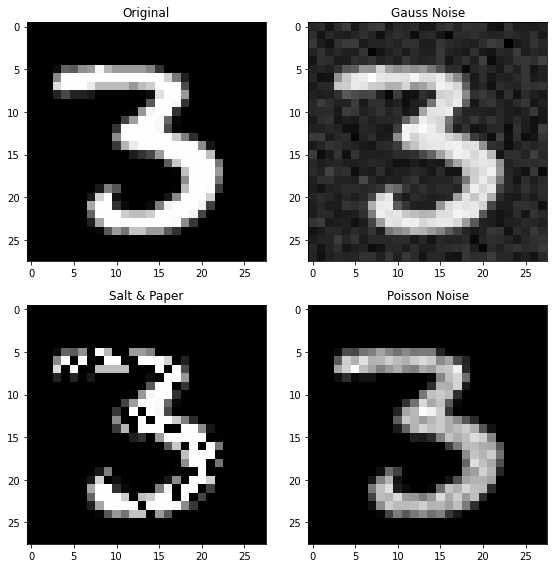

In [16]:
fig_size = (8, 8)
fig, axes = plt.subplots(2, 2, figsize = fig_size)
test_dataset_copy = test_dataset[:-1]
test_dataset_copy.insert(0, {
    'noise_type': 'Original',
        'original': sample_image / 255.0,
        'noisy_image': sample_image / 255.0
})

for idx, test_data in enumerate(test_dataset_copy):
    ax = axes[idx//2, idx %2]
    ax.set_title(test_data['noise_type'])
    ax.imshow(test_data['noisy_image'], cmap = 'gray')
fig.tight_layout()
plt.savefig('img4.png')
plt.show()

In [17]:
for test_data in test_dataset:
    test_data['denoised_image'] = np.squeeze(model.predict(np.expand_dims(test_data['noisy_image'], axis=0)), axis = 0)

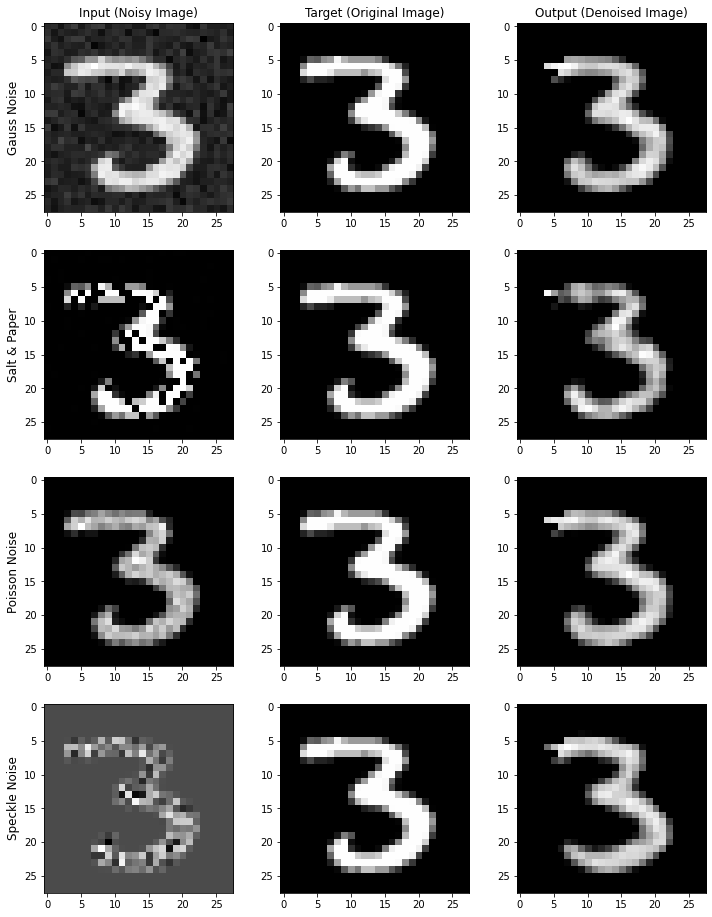

In [18]:
fig_size = (12, 16)
fig, axes = plt.subplots(4, 3, figsize = fig_size)
for idx, test_data in enumerate(test_dataset):
    ax = axes[idx, 0]
    ax.set_ylabel(test_data['noise_type'], size='large')
        
    ax = axes[idx, 0]
    ax.imshow(test_data['noisy_image'], cmap = 'gray')
    if idx == 0:
        ax.set_title('Input (Noisy Image)')
    
    ax = axes[idx, 1]
    ax.imshow(test_data['original'], cmap = 'gray')
    if idx == 0:
        ax.set_title('Target (Original Image)')
    
    ax = axes[idx, 2]
    ax.imshow(test_data['denoised_image'], cmap = 'gray')
    if idx == 0:
        ax.set_title('Output (Denoised Image)')
plt.show()